In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summer-school-2022-task-2/train_data.csv
/kaggle/input/summer-school-2022-task-2/test_data.csv
/kaggle/input/summer-school-2022-task-2/sample_submssions.csv


In [2]:
#loading the dataset
train = pd.read_csv('/kaggle/input/summer-school-2022-task-2/train_data.csv')
test = pd.read_csv('/kaggle/input/summer-school-2022-task-2/test_data.csv')
n_train = train.shape[0]
print(train.shape, test.shape)
train.head()

(208764, 16) (52192, 15)


,id,seller,offer_type,price,abtest,vehicle_type,year_of_registration,gearbox,power,model,kilometer,month_of_registration,fuel_type,brand,not_repaired_damage,postal_code
0,0,privat,Angebot,8990,control,bus,2007,automatik,136,b_klasse,125000,1,benzin,mercedes_benz,nein,55232
1,1,privat,Angebot,49900,test,suv,2011,automatik,400,cayenne,80000,6,benzin,porsche,nein,89155
2,2,privat,Angebot,7500,control,limousine,2005,manuell,0,a6,150000,11,diesel,audi,nein,26125
3,3,privat,Angebot,1350,control,limousine,1997,manuell,170,3er,150000,5,benzin,bmw,nein,37671
4,4,privat,Angebot,650,test,kombi,1998,automatik,170,e_klasse,150000,8,benzin,mercedes_benz,ja,45141


In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 25.48 MB
Memory usage after optimization is: 6.18 MB
Decreased by 75.7%
Memory usage of dataframe is 5.97 MB
Memory usage after optimization is: 1.36 MB
Decreased by 77.3%


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208764 entries, 0 to 208763
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   id                     208764 non-null  int32   
 1   seller                 208764 non-null  category
 2   offer_type             208764 non-null  category
 3   price                  208764 non-null  int32   
 4   abtest                 208764 non-null  category
 5   vehicle_type           208764 non-null  category
 6   year_of_registration   208764 non-null  int16   
 7   gearbox                208764 non-null  category
 8   power                  208764 non-null  int16   
 9   model                  208764 non-null  category
 10  kilometer              208764 non-null  int32   
 11  month_of_registration  208764 non-null  int8    
 12  fuel_type              208764 non-null  category
 13  brand                  208764 non-null  category
 14  not_repaired_damage 

In [6]:
train.describe(include = ['category'])

,seller,offer_type,abtest,vehicle_type,gearbox,model,fuel_type,brand,not_repaired_damage
count,208764,208764,208764,208764,208764,208764,208764,208764,208764
unique,2,2,2,8,2,250,7,39,2
top,privat,Angebot,test,limousine,manuell,golf,benzin,volkswagen,nein
freq,208762,208761,108590,61082,159980,16765,135504,43302,186424


training set has 208764 instances with 15 predictor variables and 1 target variable (price)

In [7]:
train['price'] = np.log1p(train['price'])

In [8]:
train.corr()['price']

id                      -0.000225
price                    1.000000
year_of_registration     0.490626
power                    0.200597
kilometer               -0.348294
month_of_registration    0.060763
postal_code              0.082855
Name: price, dtype: float64

After log transformation of 'price', predictor variables - year_of_registration, power and kilometer shown a significant level of correlation

In [9]:
train_price = train['price']
train.drop(columns = ['price'], inplace = True)

In [10]:
# joining tran and test set for preprocessing
df = pd.concat([train, test], axis = 0)
df.shape

(260956, 15)

In [11]:
def preprocess(df):
    
    df.dropna(inplace = True)
    df.drop(columns = ['id', 'postal_code'], inplace = True)
    df = pd.get_dummies(df, columns = ['seller',	'offer_type',	'abtest',	'vehicle_type',	'gearbox',	'model',	
                                 'fuel_type',	'brand',	'not_repaired_damage'])
    train = df[:n_train]
    test = df[n_train:]
    return (train, test)

In [12]:
train, test = preprocess(df)

In [13]:
train.describe()

,year_of_registration,power,kilometer,month_of_registration,seller_gewerblich,seller_privat,offer_type_Angebot,offer_type_Gesuch,abtest_control,abtest_test,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_damage_ja,not_repaired_damage_nein
count,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,...,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000
mean,2003.297863,126.385857,124031.011094,6.181717,0.000010,0.999990,0.999986,0.000014,0.479843,0.520157,...,0.017407,0.012948,0.002103,0.006558,0.014088,0.000867,0.207421,0.009978,0.107011,0.892989
std,6.528143,144.950397,39859.350281,3.472495,0.003095,0.003095,0.003791,0.003791,0.499595,0.499595,...,0.130783,0.113049,0.045809,0.080714,0.117853,0.029432,0.405460,0.099389,0.309128,0.309128
min,1910.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1999.000000,78.000000,100000.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2004.000000,116.000000,150000.000000,6.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2008.000000,150.000000,150000.000000,9.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2018.000000,17700.000000,150000.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
train_scaled = std_scaler.fit_transform(train[['year_of_registration', 'power', 'kilometer','month_of_registration']])
test_scaled = std_scaler.transform(test[['year_of_registration', 'power', 'kilometer','month_of_registration']])

In [15]:
train_scaled = pd.DataFrame(train_scaled, columns = ['year_of_registration', 'power', 'kilometer','month_of_registration'])
test_scaled = pd.DataFrame(test_scaled, columns = ['year_of_registration', 'power', 'kilometer','month_of_registration'])
train_scaled.head()

,year_of_registration,power,kilometer,month_of_registration
0,0.567106,0.066327,0.024310,-1.492221
1,1.179839,1.887644,-1.104662,-0.052331
2,0.260739,-0.871927,0.651517,1.387560
3,-0.964727,0.300891,0.651517,-0.340309
4,-0.811544,0.300891,0.651517,0.523626


In [16]:
train[['year_of_registration', 'power', 'kilometer','month_of_registration']] = train_scaled
test[['year_of_registration', 'power', 'kilometer','month_of_registration']] = test_scaled
train.head()

,year_of_registration,power,kilometer,month_of_registration,seller_gewerblich,seller_privat,offer_type_Angebot,offer_type_Gesuch,abtest_control,abtest_test,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_damage_ja,not_repaired_damage_nein
0,0.567106,0.066327,0.024310,-1.492221,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.179839,1.887644,-1.104662,-0.052331,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.260739,-0.871927,0.651517,1.387560,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.964727,0.300891,0.651517,-0.340309,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.811544,0.300891,0.651517,0.523626,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [17]:
import gc
del train_scaled
del test_scaled
gc.collect()


69

In [18]:
train.describe()

,year_of_registration,power,kilometer,month_of_registration,seller_gewerblich,seller_privat,offer_type_Angebot,offer_type_Gesuch,abtest_control,abtest_test,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_damage_ja,not_repaired_damage_nein
count,2.087640e+05,2.087640e+05,2.087640e+05,2.087640e+05,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,...,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000
mean,1.709916e-14,4.203408e-17,-1.859030e-16,-1.054085e-16,0.000010,0.999990,0.999986,0.000014,0.479843,0.520157,...,0.017407,0.012948,0.002103,0.006558,0.014088,0.000867,0.207421,0.009978,0.107011,0.892989
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.003095,0.003095,0.003791,0.003791,0.499595,0.499595,...,0.130783,0.113049,0.045809,0.080714,0.117853,0.029432,0.405460,0.099389,0.309128,0.309128
min,-1.429167e+01,-8.719270e-01,-2.986283e+00,-1.780199e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.583607e-01,-3.338106e-01,-6.028966e-01,-9.162648e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.075557e-01,-7.165128e-02,6.515172e-01,-5.233056e-02,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.202888e-01,1.629123e-01,6.515172e-01,8.116037e-01,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.252122e+00,1.212391e+02,6.515172e-01,1.675538e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


No NaN values in the provided train set

stats of numerical variables

In [19]:
skewness = train.skew()
skewness

year_of_registration         -1.386200
power                        70.541015
kilometer                    -1.373495
month_of_registration         0.073022
seller_gewerblich           323.079712
                               ...    
brand_trabant                33.917690
brand_volkswagen              1.443208
brand_volvo                   9.860742
not_repaired_damage_ja        2.542593
not_repaired_damage_nein     -2.542593
Length: 318, dtype: float64

In [20]:
train['power'] = np.log1p(train['power'])
train['power'].skew()

-1.303304743399925

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


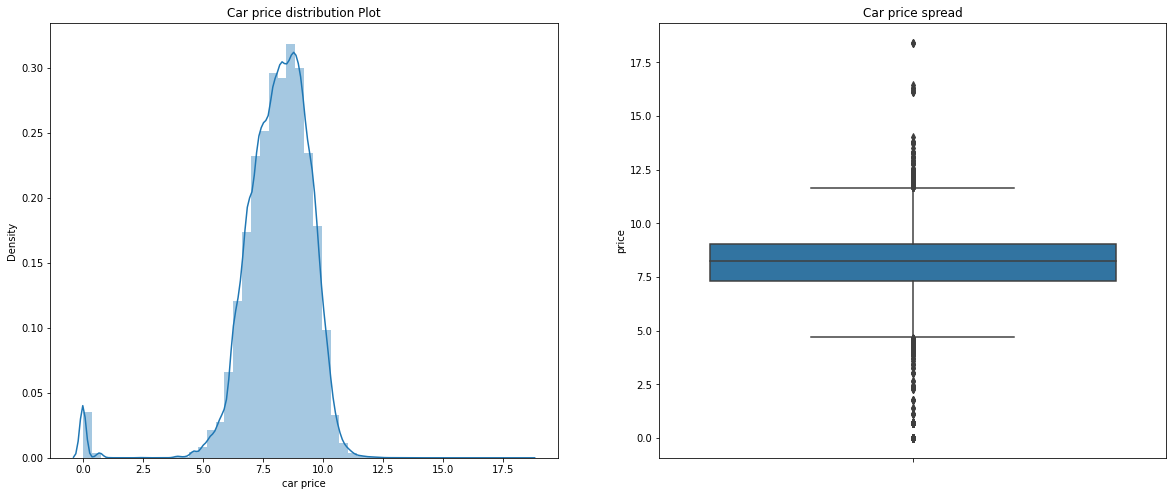

In [22]:
# car price distribution plot
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.distplot(train_price, axlabel = 'car price', kde = True)
plt.title('Car price distribution Plot')

plt.subplot(1,2,2)
sns.boxplot(y = train_price)
plt.title('Car price spread')

plt.show()


Addition of 1 with the target variable makes the logarithmic computation feasible (within floating point accuracy) even if the value of the target variable is sufficiently less

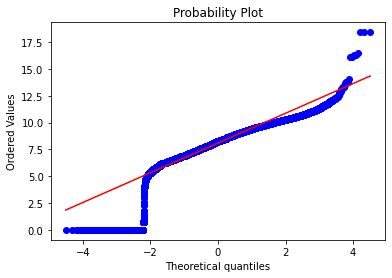

In [24]:
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.figure()
stats.probplot(train_price, plot = plt) 
plt.show()
               

Prices of cars are hightly right skewed with mean value closer to 10000

Skew value = 0 (normally distributed), positive skew value (right skewed), negative skew value (left skewed)
**Price and power of cars are highly right skewed**

288 features are right skewed and 2 features are less skewed (value chosen 5 and -5) for testing

In [25]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
trainx, valx, trainy, valy = train_test_split(train, train_price, test_size = 0.1, random_state = 1, shuffle = True)

In [26]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("lasso_reg", Lasso(alpha = 1))
])
#pipeline.fit(trainx, trainy)

param_grid = {'lasso_reg__alpha': range(1,100,10)}
grid_clf_lasso = GridSearchCV(pipeline, param_grid, cv = 3, verbose = 2)
grid_clf_lasso.fit(trainx, trainy)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .................................lasso_reg__alpha=1; total time=   1.6s
[CV] END .................................lasso_reg__alpha=1; total time=   1.4s
[CV] END .................................lasso_reg__alpha=1; total time=   1.2s
[CV] END ................................lasso_reg__alpha=11; total time=   1.2s
[CV] END ................................lasso_reg__alpha=11; total time=   1.2s
[CV] END ................................lasso_reg__alpha=11; total time=   1.2s
[CV] END ................................lasso_reg__alpha=21; total time=   1.2s
[CV] END ................................lasso_reg__alpha=21; total time=   1.2s
[CV] END ................................lasso_reg__alpha=21; total time=   1.2s
[CV] END ................................lasso_reg__alpha=31; total time=   1.2s
[CV] END ................................lasso_reg__alpha=31; total time=   1.5s
[CV] END ................................lasso_r

GridSearchCV(cv=3, estimator=Pipeline(steps=[('lasso_reg', Lasso(alpha=1))]),
             param_grid={'lasso_reg__alpha': range(1, 100, 10)}, verbose=2)

In [27]:
print('lasso_best_params:',grid_clf_lasso.best_params_)
print('lasso_score:', grid_clf_lasso.score(valx, valy))

lasso_best_params: {'lasso_reg__alpha': 1}
lasso_score: -0.00021301570685694493


In [28]:
valy_lasso_predict = grid_clf_lasso.predict(valx)
valy_lasso_predict[:5]

array([8.10200468, 8.10200468, 8.10200468, 8.10200468, 8.10200468])

In [29]:
valy_lasso_predict_transform = np.expm1(valy_lasso_predict)
valy_lasso_predict_transform[:5]

array([3300.07903782, 3300.07903782, 3300.07903782, 3300.07903782,
       3300.07903782])

In [ ]:
valy_transform = np.expm1(valy.to_numpy())
valy_transform[:5]

In [30]:
from sklearn.metrics import mean_squared_error
val_res_lasso = mean_squared_error(valy, valy_lasso_predict_transform, squared = False)
val_res_lasso

3291.999661609132

In [31]:
test_lasso_predict = grid_clf_lasso.predict(test)
test_lasso_predict[:5]

array([8.10200468, 8.10200468, 8.10200468, 8.10200468, 8.10200468])

In [33]:
test_transform = np.expm1(test_lasso_predict)
test_transform[:5]

array([3300.07903782, 3300.07903782, 3300.07903782, 3300.07903782,
       3300.07903782])

In [38]:
def submission(id, price):
    submit = pd.DataFrame()
    submit['id'] = id
    submit['price'] = price
    submit.to_csv('submission.csv', index = False)

In [36]:
test = pd.read_csv('/kaggle/input/summer-school-2022-task-2/test_data.csv')
test['id']

0            0
1            1
2            2
3            3
4            4
         ...  
52187    52187
52188    52188
52189    52189
52190    52190
52191    52191
Name: id, Length: 52192, dtype: int64

In [39]:
submission(test['id'],test_transform)

In [ ]:
test = pd.read_csv('/kaggle/input/summer-school-2022-task-2/test_data.csv')

In [ ]:
test.info()

In [ ]:
test_id = test['id']

In [ ]:
test.drop(columns = ['id', 'postal_code'], inplace = True)

In [ ]:
test['power'] = np.log1p(test['power'])
test['power'].skew()

In [ ]:
test = pd.get_dummies(test, columns = ['seller',	'offer_type',	'abtest',	'vehicle_type',	'gearbox',	'model',	
                                 'fuel_type',	'brand',	'not_repaired_damage'])
test.head()

In [ ]:
test_prediction = grid_clf_lasso.predict(test)
test_predict = np.expm1(test_prediction)
test_predict[:5]

In [ ]:
from sklearn.linear_model import SGDRegressor

pipeline = Pipeline([
        ("sgd_reg",SGDRegressor(penalty = 'elasticnet', l1_ratio = 0.1,shuffle = True, early_stopping = True, 
                       validation_fraction = 0.1, warm_start = True) )
])
#pipeline.fit(trainx, trainy)

param_grid = {'sgd_reg__l1_ratio': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
grid_clf_sgd = GridSearchCV(pipeline, param_grid, cv = 5, verbose = 2)
grid_clf_sgd.fit(trainx, trainy.values)

In [ ]:
print('elasticnet_best_params:',grid_clf_sgd.best_params_)
print('elasticnet_score:', grid_clf_sgd.score(valx, valy))

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse) 

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(y = train.brand.to_pandas(),orient = 'v')
plt.xticks(rotation = 90)
plt.title('Brand histogram')

plt.subplot(1,2,2)
brand_price = (train.groupby(['brand']).price.mean().sort_values(ascending = False)).to_pandas()
brand_price.plot.bar(x = 'brand', y = 'price', color = 'red')
plt.title("Brand vs Avg Price") 
plt.show()

Volkswagen is the predominant brand in the market while Posche bringing the costliest one

In [ ]:
def bar_plot(column_name):
    plt.figure(figsize = (6,4))
    sns.countplot(train[column_name].to_pandas())
    plt.xticks(rotation = 90)
    plt.title(column_name + ' histogram')
    plt.show()

In [ ]:
train.columns

In [ ]:
import numpy
#stats of categorical columns
train.describe(include = ['category'], exclude = [numpy.number])

Hence, it is irrelevant to plot a histogram for the feature, 'model' which has around 250 unique entries

In [ ]:
features = ['seller', 'offer_type', 'abtest', 'vehicle_type', 'gearbox', 'fuel_type', 'not_repaired_damage']
for feature in features:
    bar_plot(feature)

From the above count plots we can infer that most of the cars are sold on offer (angebot) by a private individual having manual gearbox and not repaired after damage (nein ~ no)

In [ ]:
def feature_price(features):
    plt.figure(figsize = (20,10))
    plt.subplot(1,2,1)
    brand_price = (train.groupby([feature]).price.mean().sort_values(ascending = False)).to_pandas()
    brand_price.plot.bar(x = feature, y = 'price')
    plt.title(feature + " vs Avg Price") 
    
    plt.subplot(1,2,2)
    plt.title(feature + ' vs Price')
    sns.boxplot(x=train[features].to_pandas(), y=train['price'].to_array(), palette=("PuBuGn"))
    plt.show()

In [ ]:
for feature in features:
    feature_price(feature)

From the boxplot of all features, we can conclude that the price is close to 10000 mark in respect to most of the features but the distribution is affected in some by few outliers, possibly from Posche car which sets themselves at the price range of 10^7

Relation of numeric columns with target variabel (price)

In [ ]:
train.describe(include = [numpy.number], exclude = 'category')

In [ ]:
def scatter_plot(fig_number, feature, data):
    plt.subplot(2,2,fig_number)
    plt.scatter(data[feature].to_array(), data['price'].to_array())
    plt.title(feature + ' vs price')
    plt.xlabel(feature)
    plt.ylabel('price')

In [ ]:
plt.figure(figsize = (20,15))
for i,feature in enumerate(['power', 'kilometer', 'year_of_registration'],1):
    scatter_plot(i, feature, train)

In [ ]:
from sklearn.preprocessing import RobustScaler
data = train[['year_of_registration', 'power', 'kilometer', 'price']]
trans = RobustScaler()
data = trans.fit_transform(data.as_matrix())
data = df.DataFrame(data, columns = ['year_of_registration', 'power', 'kilometer', 'price'])
data.describe()

In [ ]:
data.to_pandas().hist()

In [ ]:
plt.scatter(data['power'].to_array(), data['price'].to_array())

In [ ]:
train[['year_of_registration', 'power', 'kilometer', 'price']] = data

In [ ]:
train.head()

In [ ]:
train.drop(columns = ['id', 'month_of_registration'], inplace = True)


In [ ]:
train = df.get_dummies(train, columns = ['seller', 'offer_type', 'abtest', 'vehicle_type', 
                                    'gearbox', 'fuel_type', 'not_repaired_damage', 'model', 'brand'])

In [ ]:
train.drop(columns = ['postal_code'], inplace = True)


In [ ]:
train.head()

In [ ]:
#separating the label from predictor variables
from sklearn.model_selection import train_test_split
import gc
train = train.to_pandas()
trainy = train['price']
trainx = train.drop(labels = ['price'], axis = 1)
train_x, val_x, train_y, val_y = train_test_split(trainx, trainy, test_size = 0.1, random_state = 2, shuffle = True)
print('We have around {} training examples with {} predictor variables'.format(train_x.shape[0], train_x.shape[1]))
print("We have around {} validation examples with {} predictor variables".format(val_x.shape[0], val_x.shape[1]))
del train
del trainx
del trainy
gc.collect()


In [ ]:
import pandas
plt.figure(figsize = (30, 25))
sns.heatmap(pandas.concat([train_x, train_y], axis = 1).corr(), annot = True, cmap="YlGnBu")
plt.show()

In [ ]:
#RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
train_x.head()

In [ ]:
import numpy
lm = LinearRegression()
lm.fit(train_x.to_numpy(),train_y.to_numpy())
rfe = RFE(lm, n_features_to_select = 10)
rfe = rfe.fit(X_train, y_train)

In [ ]:
#creating submission file
def submission(id, price):
    submit = pd.DataFrame()
    submit['id'] = id
    submit['price'] = price
    submit.to_csv('submission.csv', index = False)

In [ ]:
submission(test['id'], pred_rand_reg)